# sLIME Tutorial
In this tutorial we will partially recreate the superpixel segmentation tutorial from the original [LIME repo](https://marcotcr.github.io/lime/tutorials/Tutorial%20-%20images.html).

We start by finding a picture of a cat and a dog to classify.

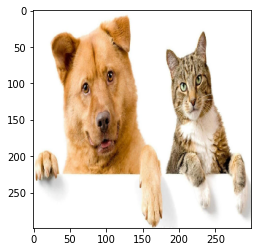

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

def display_inception_image(img):
    plt.figure()
    plt.imshow(img / 2 + 0.5)

import urllib.request
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input

urllib.request.urlretrieve("https://storage.googleapis.com/petbacker/images/blog/2017/dog-and-cat-cover.jpg", "catdog.png")
img = image.load_img('catdog.png', target_size=(299, 299))
images = image.img_to_array(img)
images = np.expand_dims(images, axis=0)
images = preprocess_input(images)
display_inception_image(images[0])
img = images[0].astype('double')

We now want to generate segments to use as features in perturbing this image. To do this, we use the same segmentation algorithm as in the original LIME implementation to generate image masks. sLIME implements a SegmentTransformer class that uses image masks to perturb the instance.

The image displayed is the output with a single superpixel enabled.

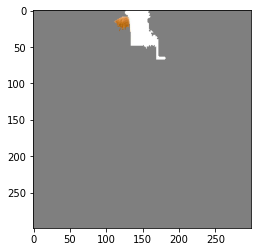

In [5]:
from lime.wrappers.scikit_image import SegmentationAlgorithm
from slime.transform import TransformerPerturber, SegmentTransformer
import tensorflow as tf

RANDOM_SEED = 5

def get_segment_transformers(img, dtype=tf.float64, kernel_size=4, max_dist=200):
  segmentation_fn = SegmentationAlgorithm('quickshift', kernel_size=kernel_size, max_dist=max_dist, ratio=0.2, random_seed=RANDOM_SEED)
  segments = segmentation_fn(img)
  segment_values = np.unique(segments)
  transformers = []
  for v in segment_values:
    mask = 1 - (segments == v)
    mask = mask[..., np.newaxis]
    mask = tf.convert_to_tensor(mask, dtype=dtype)
    transformers.append(SegmentTransformer(mask))
  img = tf.convert_to_tensor(img, dtype=dtype)
  tp = TransformerPerturber(img, transformers)
  return tp

tp = get_segment_transformers(img)
zeros = [False for _ in range(tp.feature_count)]
zeros[10] = True
display_inception_image(tp.perturb(zeros))

We use a pre-trained Inception V3 model from Keras to classify the image.

In [8]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import decode_predictions

inception = InceptionV3(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
);
preds = inception.predict(images)

predictions = decode_predictions(preds, top=5)[0]
for prediction in predictions:
  print(prediction[1], prediction[2])

1/1 [==============================] - 1s 1s/step
chow 0.30251125
Labrador_retriever 0.029034501
tabby 0.024420215
tiger_cat 0.013999985
golden_retriever 0.013686763


The most likely classification for this image is 'chow', so let's use sLIME to explain that label.

In [11]:
%%capture
from sklearn.metrics import pairwise_distances
from slime.explain import Explainer

def metric(baseline, prediction):
  return pairwise_distances(
      [prediction],
      baseline.reshape(1, -1),
      metric='cosine'
  ).ravel()

explainer = Explainer(metric, random_state=RANDOM_SEED)
explanation = explainer.explain_instance(tp, inception.predict, top_labels=5, num_features=100, num_samples=1000);

chow


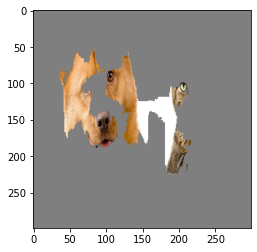

In [12]:
def readable_label(label):
  likelihoods = np.zeros((1000))
  likelihoods[label] = 1.0
  return decode_predictions(np.array([likelihoods]), top=1)[0][0][1]
  
label_to_explain = list(explanation.local_exp.keys())[0]
print(readable_label(label_to_explain))
display_inception_image(explanation.explain(label_to_explain, num_features=5))